# Fake Injection

Author: Shu Liu

This notebook demonstrates the framework of fake injection.

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from astropy.table import Table

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

In [13]:
def inject_star(exposure, photoCalib, x, y, magVar, poisson=False, seed=0):
    """This function injects a fake source onto an exposure
       exposure:    The exposure for injection
       photoCalib:  lsst.afw.image.photoCalib.PhotoCalib object
       x:           injected x pixel coordinate
       y:           injected y pixel coordinate
       magVar:      injected magnitude
       poisson:     If true, add Poisson fluctuations to the fake model
       seed:        random seed of the Poisson distribution
       
    """    
    exposure.mask.addMaskPlane("FAKE")
    bitmask = exposure.mask.getPlaneBitMask("FAKE")
    xy = geom.Point2D(x, y)
    psf = exposure.getPsf()
    starIm = psf.computeImage(xy)
    calibFluxRadius = 12
    correctedFlux = psf.computeApertureFlux(calibFluxRadius, xy)
    starIm /= correctedFlux
    flux = photoCalib.magnitudeToInstFlux(magVar, xy)
    starIm *= flux
    star_shape = starIm.array.shape
    star_array = starIm.getArray()
    star_array[star_array < 1e-19] = 0.

    if poisson:
        # The array of starIm will be changed inplace, we make a copy here to calculate the variance plane.
        star_array_copy = starIm.array.copy()
        star_array_copy = np.float32(star_array_copy)
        
        for i in range(star_shape[0]):
            for j in range(star_shape[1]):
                np.random.seed(seed)
                star_array[i][j] = np.random.poisson(star_array[i][j] * 0.7) / 0.7

    fakeImage = starIm.convertF()
    imageBBox = exposure.getBBox()
    imageMI = exposure.maskedImage

    interpFakeImage = fakeImage
    interpFakeImBBox = fakeImage.getBBox()
    interpFakeImBBox.clip(imageBBox)
    imageMIView = imageMI.Factory(imageMI, interpFakeImBBox)

    if interpFakeImBBox.getArea() > 0:
        clippedFakeImage = interpFakeImage.Factory(interpFakeImage, interpFakeImBBox)
        clippedFakeImageMI = afwImage.MaskedImageF(clippedFakeImage)
        clippedFakeImageMI.mask.set(bitmask)
        if poisson:
            clippedFakeImageMI.variance.array = star_array_copy / 0.7
        imageMIView += clippedFakeImageMI
        
def inject_fakes_to_calexp(calexp_repo, calexp_id, magVar, coords, poisson=False):
    """This function injects fakes onto a calexp exposure at given positions.
       caelxp_repo:    An empty calexp repo which is used to save the injected exposure.
       calexp_id:      The data id of the calexp exposure
       magVar:         The injected magnitude
       coords:         A list of [x, y] pixel coordinates
       poisson:        If true, add Poisson fluctuations to the fake model
    """
    
    calexp_butler = Butler(calexp_repo)
    calexp_photoCalib = calexp_butler.get('calexp_photoCalib',  calexp_id)
    calexp_exposure = calexp_butler.get('calexp', dataId=calexp_id)
    for coord in coords:
        x, y = coord[0], coord[1]
        inject_star(calexp_exposure, calexp_photoCalib, x, y, magVar, poisson=poisson)
    calexp_butler.put(calexp_exposure, 'calexp', dataId=calexp_id)

## 1. Make calexp repos for injection

To begin with, we need to create empty calexp repos for injection. Here are the steps to create an empty calexp repo:
- create an empty directory, let us call it `empty_calexp_repo`.
- under the `empty_calexp_repo` directory, create an empty directory called `calexp`.
- under teh `empty_calexp_repo` directory, create a file named `repositoryCfg.yaml` with content:

```
!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.lsst.imsim.ImsimMapper ''
_mapperArgs: {}
_parents:
- /global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/coadd-dr1b-v1-grizy
_policy: null
_root: null
dirty: true
```

An empty repo has already been created in the shared space(`/global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/empty_calexp_repo/`) of the dia team. So we can copy it for our use case. Suppose we want to create 3 repos corresponding to the injection magnitudes of 16 17, and 18 in the current working directory. We can do the following code in the terminal:

```
for ((i=16; i<=18; i=i+1 )); do cp -r /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/empty_calexp_repo/ \
./repo_$i; done
```

In [15]:
"""
! for ((i=16; i<=18; i=i+1 )); do cp -r /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/empty_calexp_repo/ \
./repo_$i; done
"""
print()

## 2. Fake Injection

Next, we inject fakes at given positions, suppose we have a list of [x, y] pixel coordinates for injection.

In [16]:
injection_coords = [[1656, 1642], [920, 1335], [2737, 2343], [2185, 974], [1703, 1316]]

We specify the data id of the exposures.

In [17]:
# Setup data id
tract, patch, filt = 4639, '0,0', 'r'
visit, detector = 181868, 57
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}

Start injection:

In [18]:
for mag in (16, 17, 18):
    repo = './repo_{}'.format(mag)
    inject_fakes_to_calexp(repo, calexp_id, mag, injection_coords, poisson=False)

## 3. Image Differencing

Now it is time to run image differencing on injected images. Let us create a script of image differencing in the current working directory.

`test_sub.sh`:


```
with open(f'./test_sub.sh', "w+") as file:
    file.write('#！/bin/bash\n\n')
    for i in (16, 17, 18):
        line = 'imageDifferenceDriver.py ./repo_{} \\\n'.format(i)
        file.write(line)
        line2 = '    --output ./diff_{} \\\n'.format(i)
        file.write(line2)
        line3 = '    --id visit=181868 detector=57  -C diffimConfig_al.py \\\n'
        file.write(line3)
        line4 = '    --clobber-config --clobber-versions --cores 4\n'
        file.write(line4)
```

We also need to create a setup file and a config file.

`setup.sh`:

```
#！/bin/bash

# For the first time, we need to cd to each repo and do scons, onece this has been achieved, we can comment out cds and scons, and only do the rest part of the file.

source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v19.0.0/loadLSST.bash
setup lsst_distrib

cd dia_pipe
scons
cd ..
setup -jr dia_pipe/

cd obs_lsst
scons
cd ..
setup -jr obs_lsst/

cd ip_diffim
scons
cd ..
setup -jr ip_diffim/

export HDF5_USE_FILE_LOCKING=FALSE
export OMP_NUM_THREADS=1

setup lsst_distrib
echo 'done'
```

`diffimConfig_al.py`:

```
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
config.imageDifference.refObjLoader.retarget(LoadIndexedReferenceObjectsTask)
config.imageDifference.refObjLoader.load('obs_lsst/config/filterMap.py')
config.imageDifference.kernelSourcesFromRef = True
config.ccdKey = 'detector'



config.imageDifference.doDecorrelation = True
config.imageDifference.convolveTemplate = True
# config.imageDifference.detection.thresholdValue = 25
# config.imageDifference.doSpatiallyVarying = True
```

To implement image differencing, here are the steps we need to follow:

- Clone [dia_pipe](https://github.com/LSSTDESC/dia_pipe), [obs_lsst](https://github.com/lsst/obs_lsst), and [ip_diffim](https://github.com/lsst/ip_diffim) from Github to the current working directory.
- source the setup.sh file.
- source the test_sub.sh file.

Then we can have subtractions in `diff_16`, `diff_17`, and `diff_18`.

## 4. Analysis

In [20]:
def remove_flag_src(src_table):
    """This function removes sources with flags.
       src_table:      The source table(astropy table) we want to apply flag selection.
    """
    FLAG_LIST = ['base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
                'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
                'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
                'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_suspectCenter']

    row_num = []
    for num, src in enumerate(src_table):
        flag_count = 0
        for flag in FLAG_LIST:
            # Here the data type is np.bool_, not python's built-in bool
            if src[flag] is np.bool_(True):
                flag_count += 1
        if flag_count == 0:
            row_num.append(num)
    good_table = src_table[row_num]
    return good_table

def check_diaSrc_detecion(check_coords, src_table, half_width=4):
    """This function checks whether dia sources have been detected at the coordinates given
       by the check_coords.
       check_coords:      A list of [x, y] pixel coordinates
       src_table:         An astropy table of dia sources(diaSrc)
       half_width:        The half length of the search width. The total searching region is 
                          x - half_width: x + half_width, y - half_width, y + half_width
       Returns:
       detected_set:      A set of diaSrc indexes(ordered as the src_table) of the detected sources
       missed_set:        A set of diaSrc indexes(ordered as the src_table) of the missed sources
       dia_list:          A list of astropy tables. The first dimension corresponds to the indexes
                          given from the check_coords. The second dimension collects the diaSrc table
                          of the matched sources. If a source is missed, it corresponds to an empty list.
                          e.g. [[diaSrc_0], [], [diaSrc_2], [],...]
            
    """

    detected_set = set()
    missed_set = set()
    dia_list = []

    for i, coord in enumerate(check_coords):
        x = coord[0]
        y = coord[1]
        
        dx = np.abs(x - src_table['base_NaiveCentroid_x']) < half_width
        dy = np.abs(y - src_table['base_NaiveCentroid_y']) < half_width
        
        dx_and_dy = np.logical_and(dx, dy)
        # np.where returns a tuple, only the first element is the index array
        row_indexs = np.where(dx_and_dy)[0]
        dia_list.append(src_table[row_indexs])
        if row_indexs.size > 0:
            detected_set.add(i)
        else:
            missed_set.add(i)
        
    return detected_set, missed_set, dia_list

In the next cell we calculate the efficiency of the injection. (efficiency = detected sources / injected sources). We also collect the diaSrc rows of each detected source.

In [32]:
efficiency = np.zeros(3)
recovery_list = []
for i, mag in enumerate((16, 17, 18)):
    repo = './diff_{}'.format(mag)
    
    butler = Butler(repo)
    src_table = butler.get('deepDiff_diaSrc', dataId=calexp_id)
    src_astropy = src_table.asAstropy()
    
    # We can also apply the flag selection here.
    # src_astropy = remove_flag_src(src_astropy)
    
    # Convert the injected magnitude to InstFlux for comparison to detections.
    dia_calib = butler.get('deepDiff_differenceExp_photoCalib', dataId=calexp_id)
    flux = dia_calib.magnitudeToInstFlux(mag)
    
    # Check detection
    diff_detected, diff_missed, dia_list = check_diaSrc_detecion(injection_coords, src_astropy, half_width=4)
    
    # Calculate the efficiency
    efficiency[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))
    
    # Create triplets to save the injected flux and the measured flux (injected_flux, measured_flux, measured_flux_err)
    # Sources correspond to no detection or multiple detections are ignored.
    for i in range(len(dia_list)):
        if len(dia_list[i]) == 0 or len(dia_list[i]) > 1:
            continue
        flux_triplet = [
            flux, dia_list[i][0]['base_PsfFlux_instFlux'], dia_list[i][0]['base_PsfFlux_instFluxErr']
        ]
        recovery_list.append(flux_triplet)

Here is the efficiency plot

Text(0, 0.5, 'efficiency')

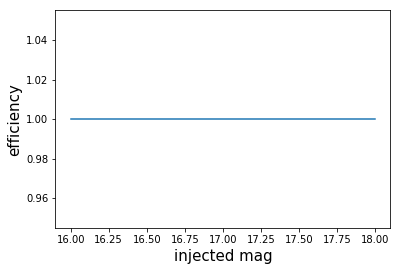

In [35]:
plt.plot((16,17,18), efficiency)
plt.xlabel('injected mag', size=15)
plt.ylabel('efficiency', size=15)

The efficiency looks good. Next, we plot the scatter of the detected flux vs. the injected flux.

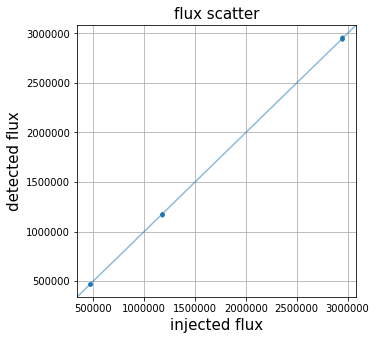

In [36]:
flux_triplet = np.array(recovery_list)
flux_triplet = flux_triplet.transpose()

fig, ax = plt.subplots(figsize=((5,5)))
ax.scatter(flux_triplet[0], flux_triplet[1], marker='.')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]
ax.plot(lims, lims, '-', alpha=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('injected flux', size=15)
ax.set_ylabel('detected flux', size=15)
ax.set_title('flux scatter', size=15)
plt.grid()

We can also plot the distribution of $\frac{\Delta Flux}{\sigma} (\Delta Flux= detectedInstFlux - injectedInstFlux$). $\sigma$ is the detected InstFlux error. We expect a standard normal distribution.

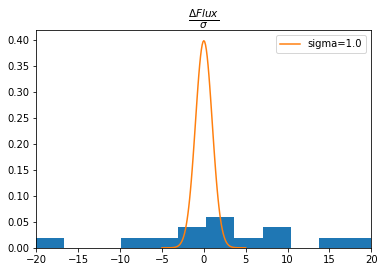

In [37]:
delta_flux = (flux_triplet[1] - flux_triplet[0]) / flux_triplet[2]
delta_flux = delta_flux.reshape(-1,1)

plt.figure()

# Plot the distribution of the data
plt.hist(delta_flux, density=True, bins=20)
plt.title(r'$\frac{\Delta Flux}{\sigma}$', size=15)
plt.xlim(-20, 20)

# Plot a standard normal distribuiton
rv10 = stats.norm(loc=0., scale=1.0)
x = np.arange(-5,5.1,0.1)
plt.plot(x, rv10.pdf(x), label='sigma=1.0')
plt.legend()

In [38]:
print(len(delta_flux))

15


It seems that we do not have enough data for statistics.

## 5. Postage Stamp

In [50]:
def make_cutout(exposure, x, y, cutout_size=60):
    """Make a cutout exposure at (x, y) pixel coordinate.
       exposure:      lsst.afw.image.exposure.exposure.ExposureF
       x:             x pixel coordinate
       y:             y pixel coordinate
       cutout_size:   Width(in pixel unit) of the postage stamp , default value is 60
    """
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def display_exposure(exposure, x, y, cutout_size=60, coord_list=None, scale=None, frame=None,
                 show_colorbar=False, title=None, save_name=None):
    """This function displays the postage stamp of an exposure. The center of the postage stamp
       is marked by a red circle. We can also overlay blue circles corresponding to the coordinaes
       given in the coord_list on the postage stamp.
       exposure:       lsst.afw.image.exposure.exposure.ExposureF
       x:              x pixel coordinate
       y:              y pixel coordinate
       cutout_size:    Width(in pixel unit) of the postage stamp , default value is 60
       coord_list:     A list of coordinates where we can overlay blue circles on the postage stamp
       scale:          [min_val, max_val], set the min value and the max value for display,
                       default is None
       frame:          The frame of the afwDisplay.Display object
       show_colorbar:  Show colorbar of the postage stamp, default is False
       title:          Title of the postage stamp
       save_name:      If provided, the postage stamp will be saved as 'save_name.png' in the current
                       working directory, default if None
    """
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    
    xy = geom.PointI(x, y)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    if show_colorbar:
        display.show_colorbar()
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    
    for coord in coord_list:
        coord_x, coord_y = coord
        display.dot('o', coord_x, coord_y, ctype='blue')
        
    
    plt.title(title)
    if save_name:
        plt.savefig(save_name, dpi=500)

We can display the postage stamp of the difference image at centered at the injection position. We also want to overlay the detected position on that postage stamp. This can be achieved using the following code.

In [39]:
# Suppose we want to make a postage stamp of the injection with mag = 16
repo = './diff_16'
butler = Butler(repo)

In [44]:
src_table = butler.get('deepDiff_diaSrc', dataId=calexp_id)
src_astropy = src_table.asAstropy()
exposure = butler.get('deepDiff_differenceExp', calexp_id)

In [45]:
diff_detected, diff_missed, dia_list = check_diaSrc_detecion(injection_coords, src_astropy, half_width=4)

In [47]:
diff_detected, diff_missed

({0, 1, 2, 3, 4}, set())

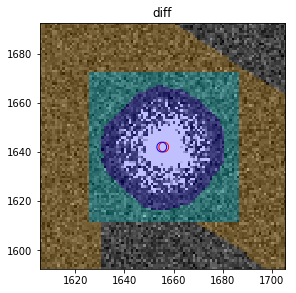

In [55]:
# Suppose we want to make a postage stamp at the first injection coordinate
idx = 0

# get detected coordinates
coords_list = []
for row in dia_list[idx]:
    detected_x, detected_y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
    coords_list.append([detected_x, detected_y])
    
x, y = injection_coords[idx][0], injection_coords[idx][1]
display_exposure(exposure, x, y, cutout_size=100, coord_list=coords_list, show_colorbar=False,
                title='diff')

The injected position is marked by the red circle, the detected position is marked by the blue circle.